In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels),nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3,padding=1)
    )

### 为什么用BN-ReLU-Conv而不是Conv-BN-Conv ###
1.将批量化和激活层放在卷积层之前，可以让卷积的输入具有更稳定的分布，有助于梯度流动  
2.实验支持....  

In [2]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        # 一个稠密块由多个卷积块组成
        for i in range(num_convs):
            # 每个卷积块的输入通道都要比上一个多num_channels
            # 输出通道一致
            layer.append(conv_block(
                num_channels*i+input_channels, num_channels
            ))
        self.net = nn.Sequential(*layer)
    
    def forward(self,X):
        for blk in self.net:
            Y = blk(X)
            # 将输入和输出在通道维上连结
            # 最终我们将会有增加num_convs*num_channels个通道
            X = torch.cat((X,Y),dim=1)
        return X
        

In [3]:
blk = DenseBlock(2,3,10)
X = torch.randn(4,3,8,8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

In [4]:
# 过渡层,稠密层输出的通道数过多，需要减少通道数
# 用1x1的卷积来减少通道数，用2x2的平均池化层减半高和宽
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        # 为什么使用平均汇聚层而不是最大汇聚层？
        # 这里只是要降低图像大小，而不是提取特征。
        # 平均汇聚层能更平滑的特征映射
        nn.AvgPool2d(kernel_size=2,stride=2)
    )

In [5]:
blk = transition_block(23,10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

In [6]:
b1 = nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
    nn.BatchNorm2d(64),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

In [7]:
# num_channels为当前通道数
num_channels, growth_rate = 64, 32
# 每个稠密层有四个卷积块，每个稠密层都会增加32*4=128个通道
num_convs_in_dense_blocks = [4,4,4,4]
blks = []
for i,num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    num_channels += num_convs*growth_rate
    # 在稠密块之间加入一个转换层，使通道数减半
    if i != len(num_convs_in_dense_blocks)-1:
        blks.append(transition_block(num_channels, num_channels//2))
        num_channels = num_channels//2

In [8]:
net = nn.Sequential(
    b1,*blks,
    nn.BatchNorm2d(num_channels),nn.ReLU(),
    nn.AdaptiveMaxPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(num_channels,10)
)

loss 0.134, train acc 0.950, test acc 0.908
2476.9 examples/sec on cuda:0


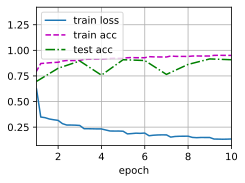

In [9]:
lr,num_epochs,batch_size = 0.1,10,128
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size,resize=96)
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())